In [93]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import CategoricalNB,GaussianNB
from tqdm import tqdm
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from itertools import combinations, chain
import matplotlib.pyplot as plt

In [94]:
# Because dividing our very small dataset into training and test data can yield very different results, we are running them a number of times and averaging the accuracy.
# Higher number yields a more accurate result but also takes longer
EVALUATION_RUNS = 2

TOP_PERCENTAGE = 1

# Represents the proportion of the dataset used for training. Remaining will be used for validation.
TRAIN_SIZE = 0.7


TRAINING_RUNS = 1000

In [95]:
# Load dataset

source = pd.read_csv("./SAKI Exercise 1 - Transaction Classification - Data Set.csv", delimiter=";")
labels = source["label"]
source.drop("Unnamed: 0", axis=1, inplace=True)
source.drop("label", axis=1, inplace=True)

source.head()

,Auftragskonto,Buchungstag,Valutadatum,Buchungstext,Verwendungszweck,Beguenstigter/Zahlungspflichtiger,Kontonummer,BLZ,Betrag,Waehrung
0,89990201.0,28.07.2016,28.07.2016,Lohn / Gehalt,Gehalt Adorsys GmbH & Co. KG End-To-End-Ref.: ...,Adorsys GmbH & Co. KG,7807800780,25190001,2000.00,EUR
1,89990201.0,27.07.2016,27.07.2016,Miete,Byladem1Sbt De12773501123456789889 Miete Beuth...,Georg Tasche,DE31251900019123456780,VOHADE2HXXX,-670.00,EUR
2,89990201.0,21.07.2016,21.07.2016,Bargeld,"21.07/16.34Uhr Nuernberg All Eur 70,00 Geb.Eur...",Bargeld,9999900780,25190001,-70.00,EUR
3,89990201.0,20.07.2016,20.07.2016,Lebensmittel / Getraenke,2831 Edeka Neubauer Nuernb.//Nuernb 2016-07-20...,Kartenzahlung,9736000780,25190001,-73.21,EUR
4,89990201.0,18.07.2016,18.07.2016,Spontanausgabe,Amazon,neue Playstation,9988776655,25125100,-363,EUR


In [96]:
# Convert all ibans to regular bank number 
def clean_banking_data(df):
  for i in range(len(df.index)):
    raw = str(df.loc[i, "Kontonummer"])
    # Split the iban and overwrite Kontonummer and BLZ
    if len(raw) == 22:
      df.loc[i,"BLZ"] = str(raw[4:12])
      df.loc[i,"Kontonummer"] = str(raw[12:])


clean_banking_data(source)
source.head()

,Auftragskonto,Buchungstag,Valutadatum,Buchungstext,Verwendungszweck,Beguenstigter/Zahlungspflichtiger,Kontonummer,BLZ,Betrag,Waehrung
0,89990201.0,28.07.2016,28.07.2016,Lohn / Gehalt,Gehalt Adorsys GmbH & Co. KG End-To-End-Ref.: ...,Adorsys GmbH & Co. KG,7807800780,25190001,2000.00,EUR
1,89990201.0,27.07.2016,27.07.2016,Miete,Byladem1Sbt De12773501123456789889 Miete Beuth...,Georg Tasche,9123456780,25190001,-670.00,EUR
2,89990201.0,21.07.2016,21.07.2016,Bargeld,"21.07/16.34Uhr Nuernberg All Eur 70,00 Geb.Eur...",Bargeld,9999900780,25190001,-70.00,EUR
3,89990201.0,20.07.2016,20.07.2016,Lebensmittel / Getraenke,2831 Edeka Neubauer Nuernb.//Nuernb 2016-07-20...,Kartenzahlung,9736000780,25190001,-73.21,EUR
4,89990201.0,18.07.2016,18.07.2016,Spontanausgabe,Amazon,neue Playstation,9988776655,25125100,-363,EUR


In [97]:
# Extract day, month, year out of `Buchungstag` and `Valutadatum`
def clean_dates(df):
  for i in range(len(df.index)):
    buchungstag = df.loc[i,"Buchungstag"].split(".")
    df.loc[i, "buchungstag"] = buchungstag[0]
    df.loc[i, "buchungsmonat"] = buchungstag[1]
    df.loc[i, "buchungsjahr"] = buchungstag[2]

    valutadatum = df.loc[i,"Valutadatum"].split(".")
    df.loc[i, "valutatag"] = valutadatum[0]
    df.loc[i, "valutamonat"] = valutadatum[1]
    df.loc[i, "valutajahr"] = valutadatum[2]

  df.drop("Valutadatum", axis=1,inplace=True)


clean_dates(source)
source.head()

,Auftragskonto,Buchungstag,Buchungstext,Verwendungszweck,Beguenstigter/Zahlungspflichtiger,Kontonummer,BLZ,Betrag,Waehrung,buchungstag,buchungsmonat,buchungsjahr,valutatag,valutamonat,valutajahr
0,89990201.0,28.07.2016,Lohn / Gehalt,Gehalt Adorsys GmbH & Co. KG End-To-End-Ref.: ...,Adorsys GmbH & Co. KG,7807800780,25190001,2000.00,EUR,28,07,2016,28,07,2016
1,89990201.0,27.07.2016,Miete,Byladem1Sbt De12773501123456789889 Miete Beuth...,Georg Tasche,9123456780,25190001,-670.00,EUR,27,07,2016,27,07,2016
2,89990201.0,21.07.2016,Bargeld,"21.07/16.34Uhr Nuernberg All Eur 70,00 Geb.Eur...",Bargeld,9999900780,25190001,-70.00,EUR,21,07,2016,21,07,2016
3,89990201.0,20.07.2016,Lebensmittel / Getraenke,2831 Edeka Neubauer Nuernb.//Nuernb 2016-07-20...,Kartenzahlung,9736000780,25190001,-73.21,EUR,20,07,2016,20,07,2016
4,89990201.0,18.07.2016,Spontanausgabe,Amazon,neue Playstation,9988776655,25125100,-363,EUR,18,07,2016,18,07,2016


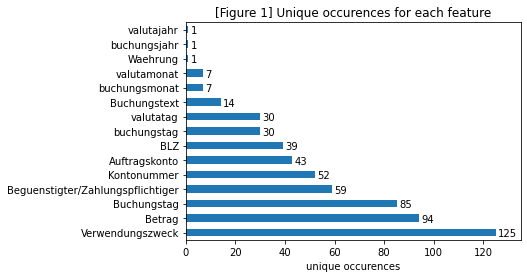

In [98]:


def plot_unique_occurences(df):
  features = df.keys()
  plot_df = pd.DataFrame(
      {
      "features":features,
      "unique_occurences":[len(set(df[feature])) for feature in features]
      },
      index=features)


  plot_df = plot_df.sort_values("unique_occurences", ascending=False)
  ax = plot_df.unique_occurences.plot(kind="barh")

  ax.set_xlabel("unique occurences")
  ax.set_title("[Figure 1] Unique occurences for each feature")
  ax.set_xlim(0,max(plot_df["unique_occurences"]+10))
  for i in ax.patches:
    ax.text(i.get_width()+1,i.get_y(),str(i.get_width()),fontsize=10)


plot_unique_occurences(source)

Easy to see that `Waehrung`, `valutajahr` and `buchungsjahr` hold no information as it is equal across all features.

`Auftragskonto` only has a single value or NULL, and we remove it manually.
It is expected to be equal across all datapoints because we are looking at a single bank account.



In [99]:
# Remove columns with no information
source.drop("valutajahr", axis=1, inplace=True)
source.drop("Waehrung", axis=1, inplace=True)
source.drop("buchungsjahr", axis=1, inplace=True)
source.drop("Auftragskonto", axis=1, inplace=True)

In [100]:
# Creates all combinations of features.
# [x,y,z] => [[x,y,z],[x,y],[x,z],[y,z],[x],[y],[z],[]]
def create_combinations(df):
  return list(filter(lambda combination: len(combination) > 0, list(chain.from_iterable(combinations(df.keys(),n) for n in range(len(df.keys())+1))))

)



def encode_feature(name):
  return LabelEncoder().fit_transform(list(source[name]))


def create_train_test_sets(df, combination, labels):
  encoder = LabelEncoder()
  encoded_features = []
  # TODO: encode features after split
  encoded_features = list(zip(*list(map(
    encode_feature,
    combination
    ))))
  encoded_labels = encoder.fit_transform(labels)
  return train_test_split(encoded_features,encoded_labels, shuffle=True,train_size=TRAIN_SIZE)

# Train and predict with a specifig set of features
# Returns the average accuracy over `EVALUATION_RUNS` runs for the feature set.
def evaluate_combination(df, features, runs):
  accuracies = []
  for i in range(runs):
    x_train,x_test,y_train,y_test = create_train_test_sets(df, features, labels)
    model = GaussianNB()
    model.fit(x_train,y_train)
    accuracies.append(accuracy_score(y_test,model.predict(x_test)))
  return accuracies



def rank_combinations(df, combinations):
  combinations_with_accuracy = []
  for features in tqdm(combinations):
    accuracies = evaluate_combination(df,features, EVALUATION_RUNS)
    combinations_with_accuracy.append({"features": features, "accuracy": sum(accuracies) / len(accuracies)})
  return combinations_with_accuracy


In [101]:

combinations = create_combinations(source)
ranked_combinations = rank_combinations(source, combinations)
top = pd.DataFrame(ranked_combinations).sort_values("accuracy", ascending=False)
print("\n")
print(top.head(5))


100%|██████████| 2047/2047 [00:10<00:00, 199.20it/s]

                                               features  accuracy
1278  (Buchungstext, Verwendungszweck, Beguenstigter...  0.793651
1940  (Buchungstext, Verwendungszweck, Beguenstigter...  0.793651
1166  (Buchungstag, Verwendungszweck, Beguenstigter/...  0.785714
1695  (Buchungstext, Verwendungszweck, Beguenstigter...  0.785714
1521  (Buchungstag, Buchungstext, Verwendungszweck, ...  0.777778



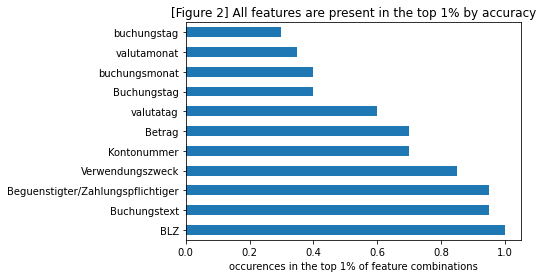

In [102]:

# Flatens and counts features
# Returns how many times each features was used in a set of combinations 
def count(arr):
    counts = {}
    for feature in [i for _tuple in arr for i in _tuple]: # -5pkt ?
        if feature not in counts:
            counts[feature] = 0
        counts[feature] +=1
    return counts

def get_best_features(source, ranked_combinations):
    df = pd.DataFrame(ranked_combinations).sort_values("accuracy", ascending=False)
    # Take the `TOP_PERCENTAGE` features only
    top_features = df.head(int(len(df.index)*TOP_PERCENTAGE/100))["features"]


    counts = count(top_features)
    for key, value in counts.items():
        counts[key] = value / len(top_features)

    return counts


def plot_best_features(counts):
    df = pd.Series(counts).sort_values(ascending=False)
    ax = df.plot(kind="barh", label="ratio")
    ax.set_xlabel("occurences in the top {}% of feature combinations".format(TOP_PERCENTAGE))
    ax.set_title("[Figure 2] All features are present in the top {}% by accuracy".format(TOP_PERCENTAGE))
    


best_features = get_best_features(source, ranked_combinations)
plot_best_features(best_features)

Next we are focusing on all features that are present in more than half of the top 1%:


In [103]:

# The features I am actually using to get the highest accuracy
used_features = list({k: v for k, v in best_features.items() if v >= 0.5}.keys())
print(used_features)

['Buchungstext', 'Verwendungszweck', 'Beguenstigter/Zahlungspflichtiger', 'Kontonummer', 'BLZ', 'valutatag', 'Betrag']


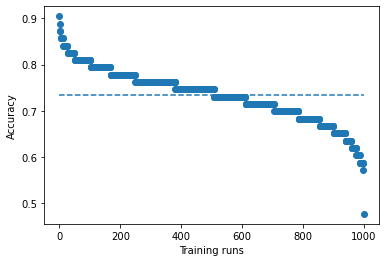

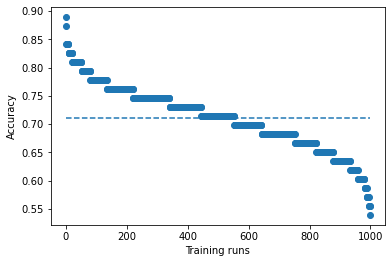

In [104]:
def plot_results(accuracies):
    fig, ax = plt.subplots()
    y = accuracies
    y.sort(reverse=True)
    x = range(0,len(accuracies))
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Training runs")
    # ax.set_title(features.join(" "))
    ax.scatter(
        x=x,
        y=y,
        label="Accuracy"
        )
    ax.plot(x,[sum(accuracies)/len(accuracies)]*len(x),label="Average", linestyle="--")
    
def run(features):
    accuracies = evaluate_combination(source, features, TRAINING_RUNS)
    plot_results(accuracies)
    





run(used_features)
run(source.keys())